# Markovian Model for steady-state throughput CUBIC and Hybla
This notebook is based on the model presented in the paper by Bao Wong and Leung. First we implement the model for CUBIC as presented in the paper (we call it the timeBased model, since the loss model is that the inter-packet loss time is assumed Poisson). Then we adapt the model to work with Hybla.

Note: Along the way, we noticed that the model is not very realistic as it assumes a time based error model. However, errors are dependent on the number of packets sent. This is why we propose a new model (that we call the packetBased model). It can be found in the packetBasedMarkovianModel.ipynb file.

## Implementing the model for CUBIC

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ccaModels import CCA_MarkovChain_CUBIC_time, CCA_MarkovChain_Hybla_time

#plt.rcParams['text.usetex'] = True
plt.rcParams.update(plt.rcParamsDefault)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


First we start with an introductory example showing the transition probabilities of different states.

Average throughput is 0.8620190739534698


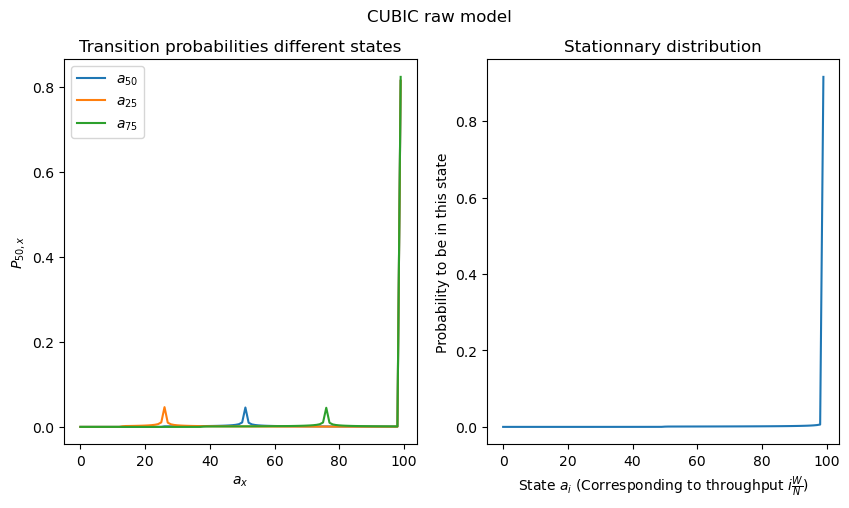

In [2]:
wired = CCA_MarkovChain_CUBIC_time(err_rate=0.05,beta=0.5,alpha=1,N=100,C =1000)
wired.avg_throughput()
print(f"Average throughput is {wired.ssThroughput}")

fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].plot(np.arange(wired.N),wired.P[50,:],label = "$a_{50}$")
axs[0].plot(np.arange(wired.N),wired.P[25,:],label = "$a_{25}$")
axs[0].plot(np.arange(wired.N),wired.P[75,:],label = "$a_{75}$")
axs[0].set_title(r"Transition probabilities different states")
axs[0].set_ylabel(r"$P_{50,x}$")
axs[0].set_xlabel(r"$a_x$")
axs[0].legend()
axs[1].plot(np.arange(wired.N),wired.pi)
axs[1].set_title(r"Stationnary distribution")
axs[1].set_xlabel(r"State $a_i$ (Corresponding to throughput $i\frac{W}{N}$)")
axs[1].set_ylabel(r'Probability to be in this state')
fig.suptitle("CUBIC raw model")
plt.show()

Now we try to reproduce the different figures form the original paper.

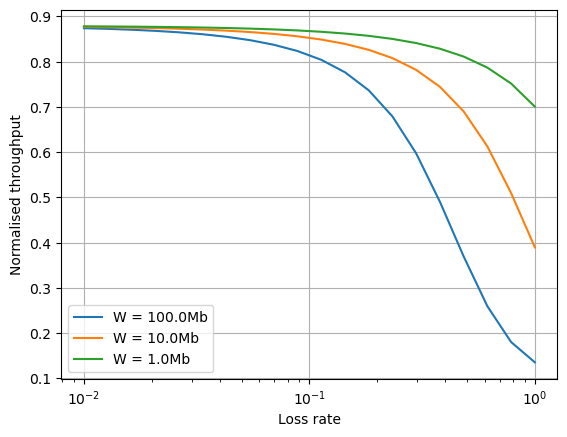

In [3]:
# Reproducing Fig. 5 (changing the RTT)
link = CCA_MarkovChain_CUBIC_time(beta = 0.5, alpha=1,N=100,C =1000)
loss_rates = np.logspace(-2,0,20)
rtts = [0.1,0.01,0.001]
throughputs = np.zeros((len(loss_rates),len(rtts)))
for j,rtt in enumerate(rtts):
    link.RTT_real = rtt
    link.update()
    for i,l in enumerate(loss_rates):
        link.err_rate = l
        link.avg_throughput()
        throughputs[i,j] = link.ssThroughput

# Now plot the throughput as a function of the loss rate with series representing the RTT
fig, ax = plt.subplots()
for j,rtt in enumerate(rtts):
    ax.plot(loss_rates,throughputs[:,j],label = f"W = {1000*rtt}Mb")
ax.set_xscale('log')
ax.set_xlabel("Loss rate")
ax.set_ylabel("Normalised throughput")
ax.legend()
plt.grid()
plt.show()

Text(0, 0.5, 'Normalised throughput')

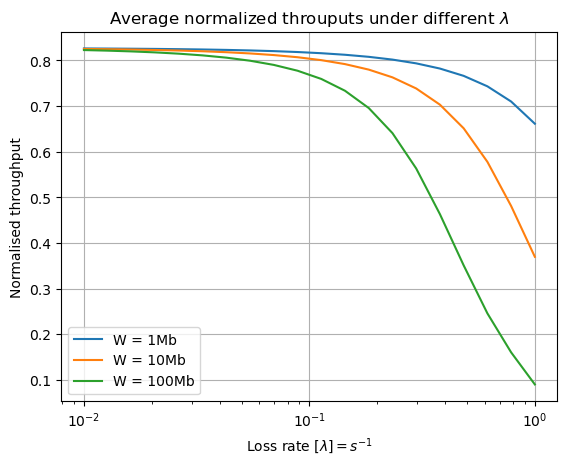

In [6]:
# Fig 5. from paper (Changing C, the bandwidth)
err_rates = np.logspace(-2,0,20)
throughputs = np.zeros([3,len(err_rates)])
for k,C in enumerate([10,100,1000]):
    for i, l in enumerate(err_rates):
        wired = CCA_MarkovChain_CUBIC_time(err_rate=l,beta=0.5,alpha=1,N=100,C = C ,RTT_real=0.1)
        throughputs[k,i] = wired.avg_throughput()

plt.plot(err_rates,throughputs[0,:], label = "W = 1Mb")
plt.plot(err_rates,throughputs[1,:], label = "W = 10Mb")
plt.plot(err_rates,throughputs[2,:], label = "W = 100Mb")
plt.semilogx()
plt.legend()
plt.ylim([0,1])
plt.grid()
plt.title(r"Average normalized throuputs under different $\lambda$")
plt.xlabel(r"Loss rate $[\lambda] = s^{-1}$")
plt.ylabel(r'Normalised throughput')

Text(0, 0.5, 'Normalised throughput')

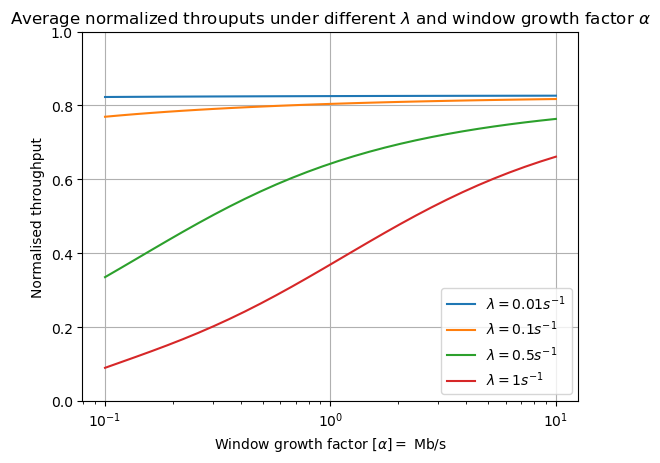

In [7]:
# Fig. 6
alphas = np.logspace(-1,1,30)
throughputs = np.zeros([4,len(alphas)])
for k,lam in enumerate([0.01,0.1,0.5,1]):
    for i, alpha in enumerate(alphas):
        wired = CCA_MarkovChain_CUBIC_time(err_rate=lam,beta=0.5,alpha=alpha,N=100,C=100,RTT_real=0.1)
        throughputs[k,i] = wired.avg_throughput()

plt.plot(alphas,throughputs[0,:], label = r"$\lambda = 0.01 s^{-1}$")
plt.plot(alphas,throughputs[1,:], label = r"$\lambda = 0.1 s^{-1}$")
plt.plot(alphas,throughputs[2,:], label = r"$\lambda = 0.5 s^{-1}$")
plt.plot(alphas,throughputs[3,:], label = r"$\lambda = 1 s^{-1}$")
plt.semilogx()
plt.legend()
plt.ylim([0,1])
plt.grid()
plt.title(r"Average normalized throuputs under different $\lambda$ and window growth factor $\alpha$")
plt.xlabel(r"Window growth factor $[\alpha] =$ Mb/s")
plt.ylabel(r'Normalised throughput')

Text(0, 0.5, 'Normalised throughput')

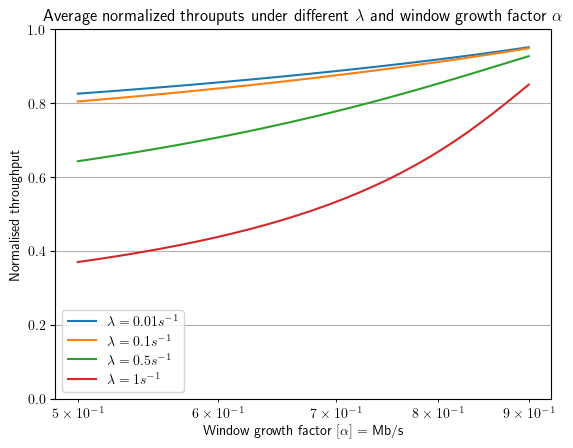

In [11]:
# same as before but with beta instead of alpha
betas = np.linspace(0.5,0.9,30)
throughputs = np.zeros([4,len(betas)])
for k,lam in enumerate([0.01,0.1,0.5,1]):
    for i, beta in enumerate(betas):
        wired = CCA_MarkovChain_CUBIC_time(err_rate=lam,beta=beta,alpha=1,N=100,C=100,RTT_real=0.1)
        throughputs[k,i] = wired.avg_throughput()

plt.plot(betas,throughputs[0,:], label = r"$\lambda = 0.01 s^{-1}$")
plt.plot(betas,throughputs[1,:], label = r"$\lambda = 0.1 s^{-1}$")
plt.plot(betas,throughputs[2,:], label = r"$\lambda = 0.5 s^{-1}$")
plt.plot(betas,throughputs[3,:], label = r"$\lambda = 1 s^{-1}$")
plt.legend()
plt.ylim([0,1])
plt.grid()
plt.title(r"Average normalized throuputs under different $\lambda$ and window growth factor $\alpha$")
plt.xlabel(r"Window growth factor $[\alpha] =$ Mb/s")
plt.ylabel(r'Normalised throughput')

## Adapting the model to Hybla

Now we adapt the model to Hybla, the main difference is in the growth time (since it is another growth function).

Average normalised throughput is 12.717626545707791


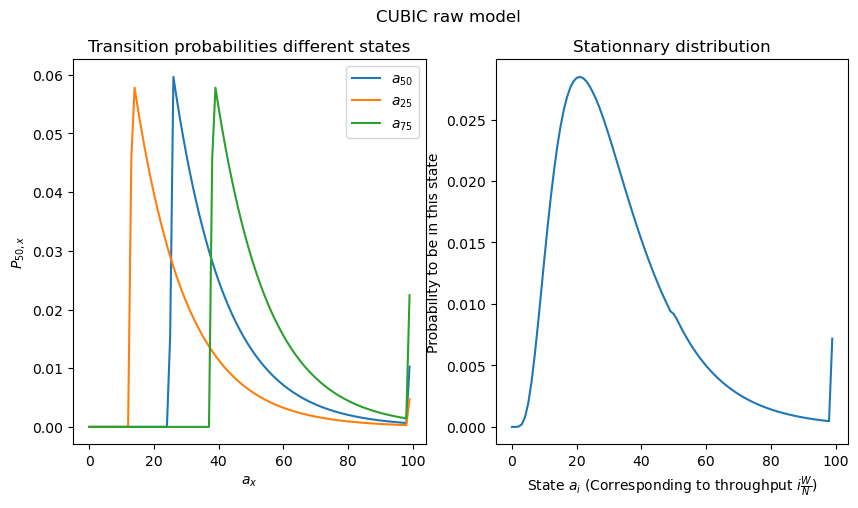

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from ccaModels import CCA_MarkovChain_Hybla_time

wired = CCA_MarkovChain_Hybla_time(err_rate=10,beta=0.5,N=100,C =1000)
wired.avg_throughput()
print(f"Average normalised throughput is {wired.ssThroughput}")

fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].plot(np.arange(wired.N),wired.P[50,:],label = "$a_{50}$")
axs[0].plot(np.arange(wired.N),wired.P[25,:],label = "$a_{25}$")
axs[0].plot(np.arange(wired.N),wired.P[75,:],label = "$a_{75}$")
axs[0].set_title(r"Transition probabilities different states")
axs[0].set_ylabel(r"$P_{50,x}$")
axs[0].set_xlabel(r"$a_x$")
axs[0].legend()
axs[1].plot(np.arange(wired.N),wired.pi)
axs[1].set_title(r"Stationnary distribution")
axs[1].set_xlabel(r"State $a_i$ (Corresponding to throughput $i\frac{W}{N}$)")
axs[1].set_ylabel(r'Probability to be in this state')
fig.suptitle("CUBIC raw model")
plt.show()

Text(0, 0.5, 'Normalised throughput')

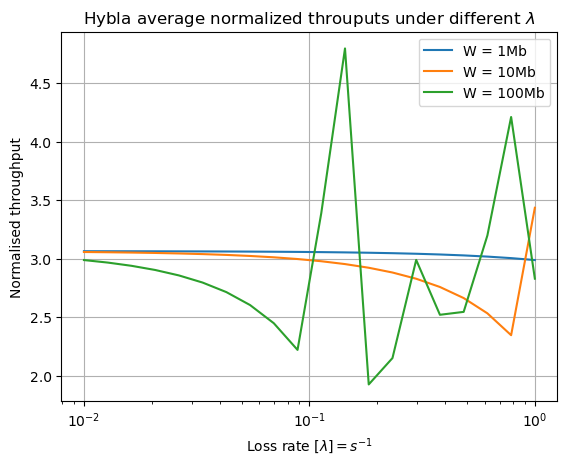

In [2]:
err_rates = np.logspace(-2,0,20)
throughputs = np.zeros([3,len(err_rates)])
for k,C in enumerate([10,100,1000]):
    for i, l in enumerate(err_rates):
        wired = CCA_MarkovChain_Hybla_time(err_rate=l,beta=0.5,N=100,C = C ,RTT_real=0.1, RTT0=0.025,alpha =1)
        throughputs[k,i] = wired.avg_throughput()

plt.plot(err_rates,throughputs[0,:], label = "W = 1Mb")
plt.plot(err_rates,throughputs[1,:], label = "W = 10Mb")
plt.plot(err_rates,throughputs[2,:], label = "W = 100Mb")
plt.semilogx()
plt.legend()
plt.grid()
plt.title(r"Hybla average normalized throuputs under different $\lambda$")
plt.xlabel(r"Loss rate $[\lambda] = s^{-1}$")
plt.ylabel(r'Normalised throughput')

In [13]:
wireless = CCA_Hybla_MarkovChain(trans_err=0.1,beta=0.5,alpha=1,N=100,C = 1000, RTT = 0.5, RTT0=0.025)
print(wireless.avg_throughput())
wired = CCA_CUBIC_MarkovChain(trans_err=0.1,beta=0.5,alpha=1,N=100,C =1000,RTT=0.5)
print(wired.avg_throughput())

0.4085971799296745
0.7081852900931365


In [34]:
err_rates = np.logspace(-2,0,20)
throughputs_hybla_bandwidth = np.zeros([3,len(err_rates)])
throughputs_cubic_bandwidth = np.zeros([3,len(err_rates)])
throughputs_hybla_rtt = np.zeros([3,len(err_rates)])
throughputs_cubic_rtt = np.zeros([3,len(err_rates)])

for k,C in enumerate([10,100,1000]):
    for i, l in enumerate(err_rates):
        wireless = CCA_Hybla_MarkovChain(trans_err=l,beta=0.5,alpha=1,N=100, C = C, RTT=0.1, RTT0=0.025)
        throughputs_hybla_bandwidth[k,i] = wireless.avg_throughput()
        wired = CCA_CUBIC_MarkovChain(trans_err=l,beta=0.5,alpha=1,N=100,C = C, RTT = 0.1)
        throughputs_cubic_bandwidth[k,i] = wired.avg_throughput()

for k,R in enumerate([0.025,0.1,0.6]):
    for i,l in enumerate(err_rates):
        wireless = CCA_Hybla_MarkovChain(trans_err=l,beta=0.5,alpha=1,N=100, C = 100, RTT=R, RTT0=0.025)
        throughputs_hybla_rtt[k,i] = wireless.avg_throughput()
        wired = CCA_CUBIC_MarkovChain(trans_err=l,beta=0.5,alpha=1,N=100,C = 100, RTT = R)
        throughputs_cubic_rtt[k,i] = wired.avg_throughput()

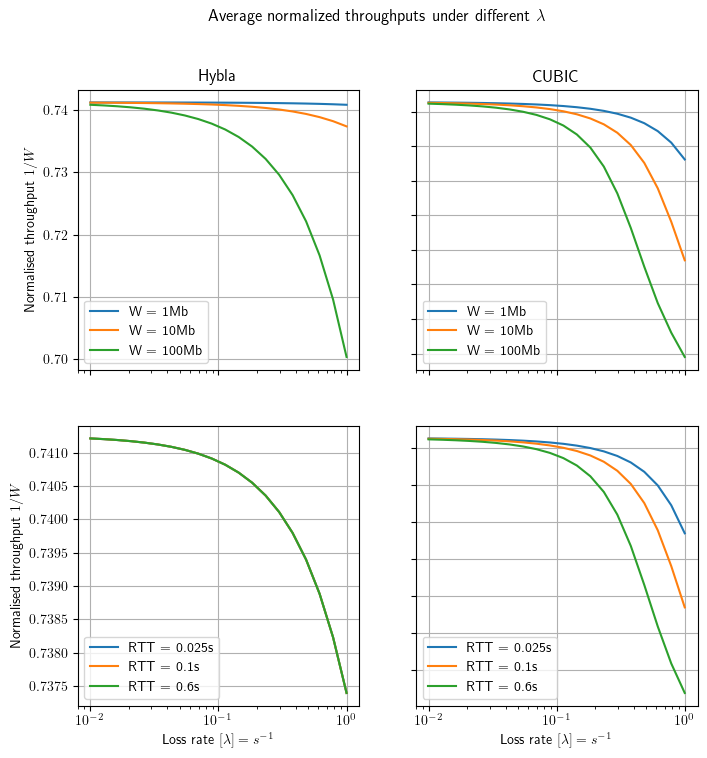

In [40]:
fig, axs = plt.subplots(2, 2)
fig.suptitle("Average normalized throughputs under different $\lambda$")
fig.set_figheight(8)
fig.set_figwidth(8)

axs[0, 0].plot(err_rates, throughputs_hybla_bandwidth[0,:],label = "W = 1Mb")
axs[0,0].plot(err_rates,throughputs_hybla_bandwidth[1,:], label = "W = 10Mb")
axs[0,0].plot(err_rates,throughputs_hybla_bandwidth[2,:], label = "W = 100Mb")
axs[0,0].semilogx()
axs[0,0].legend()
axs[0,0].grid()
axs[0,0].set_title(r"Hybla")

axs[0,1].plot(err_rates, throughputs_cubic_bandwidth[0,:],label = "W = 1Mb")
axs[0,1].plot(err_rates,throughputs_cubic_bandwidth[1,:], label = "W = 10Mb")
axs[0,1].plot(err_rates,throughputs_cubic_bandwidth[2,:], label = "W = 100Mb")
axs[0,1].semilogx()
axs[0,1].legend()
axs[0,1].grid()
axs[0,1].set_title(r"CUBIC")

axs[1,0].plot(err_rates, throughputs_hybla_rtt[0,:],label = "RTT = 0.025s")
axs[1,0].plot(err_rates,throughputs_hybla_rtt[1,:], label = "RTT = 0.1s")
axs[1,0].plot(err_rates,throughputs_hybla_rtt[2,:], label = "RTT = 0.6s")
axs[1,0].semilogx()
axs[1,0].legend()
axs[1,0].grid()

axs[1,1].plot(err_rates, throughputs_cubic_rtt[0,:],label = "RTT = 0.025s")
axs[1,1].plot(err_rates,throughputs_cubic_rtt[1,:], label = "RTT = 0.1s")
axs[1,1].plot(err_rates,throughputs_cubic_rtt[2,:], label = "RTT = 0.6s")
axs[1,1].semilogx()
axs[1,1].legend()
axs[1,1].grid()

for ax in axs.flat:
    ax.set(xlabel=r"Loss rate $[\lambda] = s^{-1}$", ylabel=r'Normalised throughput $1/W$')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()